<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256/resized/15*15/caltech256_15_15_Gabor_Same.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image-aspect-preserved.zip -d caltech-256-image-aspect-preserved

In [29]:
ITERATION = 2
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 64
DATA_DIRECTORY = "caltech-256-image-aspect-preserved/caltech-256-image-aspect-preserved/"

In [30]:
filenames = os.listdir(DATA_DIRECTORY)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

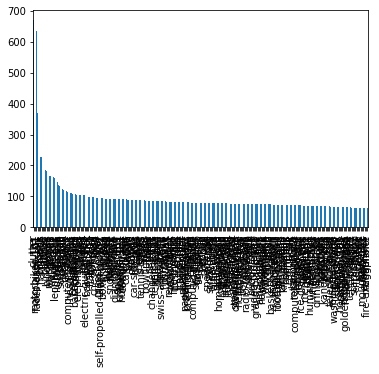

In [32]:
train_df['category'].value_counts().plot.bar()

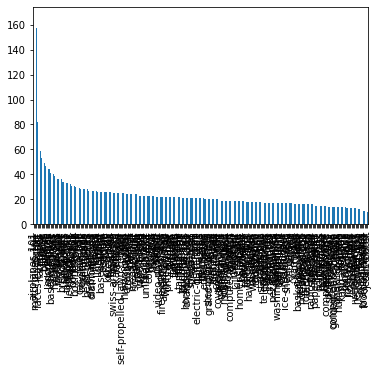

In [33]:
validate_df['category'].value_counts().plot.bar()

In [34]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [35]:
validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_DIRECTORY, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


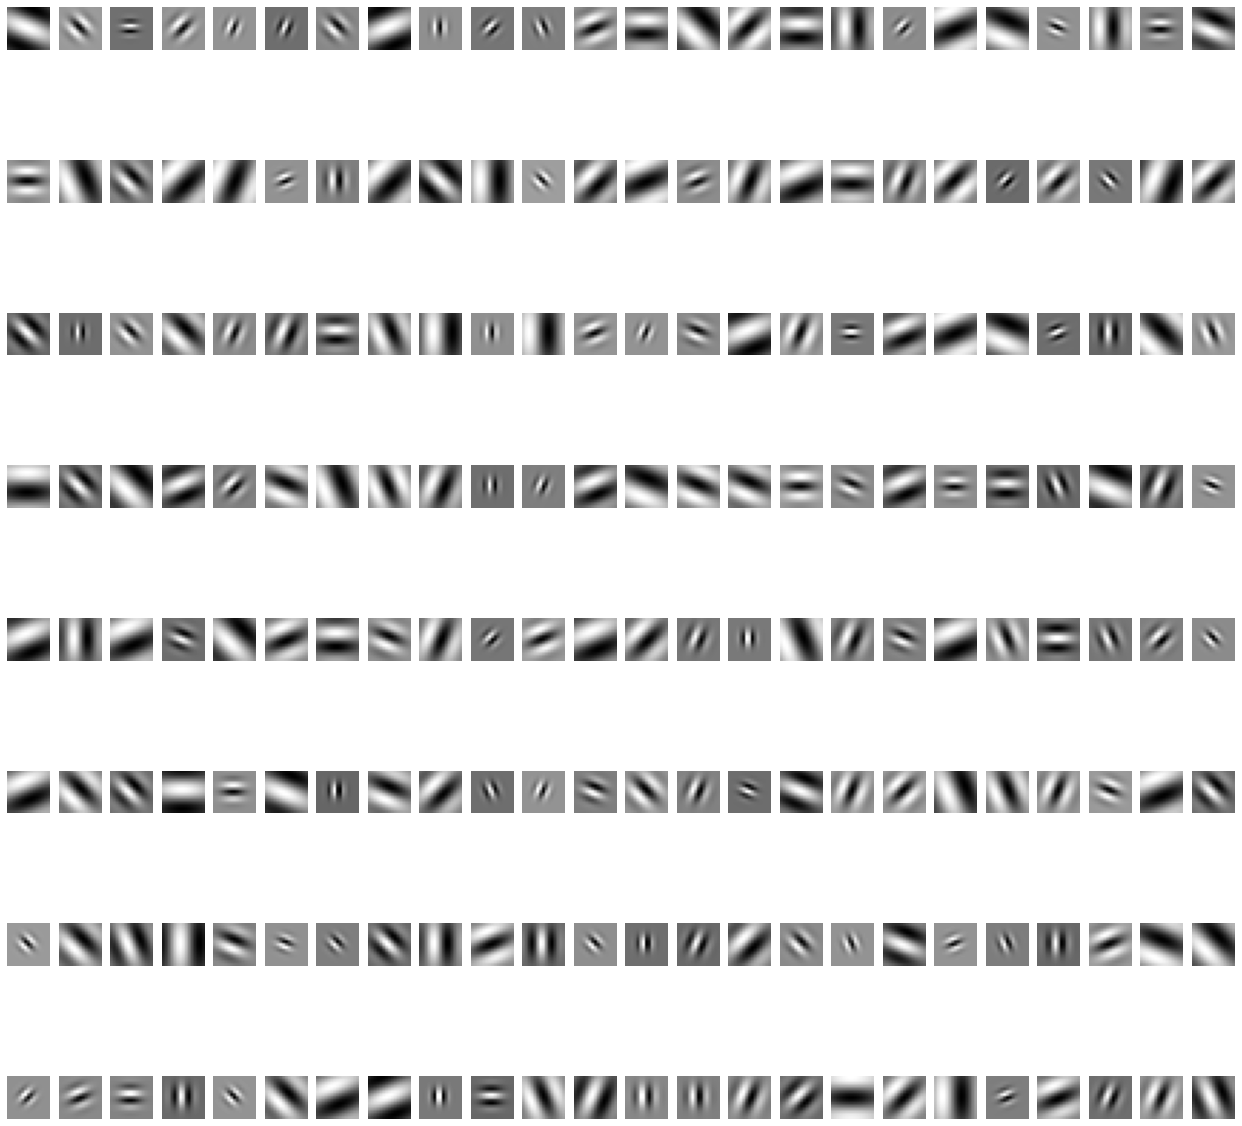

In [36]:
import math

def get_gabor_filters(inchannels, outchannels, kernel_size = (3,3)):
    delta = 1e-4
    freqs = (math.pi/2)*(math.sqrt(2)**(-np.random.randint(0,5, (outchannels, inchannels))))
    thetas = (math.pi/8)*np.random.randint(0,8, (outchannels, inchannels))
    sigmas = math.pi/(freqs)
    psis = math.pi * np.random.rand(outchannels, inchannels)
    x0, y0 = np.ceil(np.array(kernel_size)/2)    
    
    y, x = np.meshgrid(
            np.linspace(-x0 + 1, x0 + 0, kernel_size[0]),
            np.linspace(-y0 + 1, y0 + 0, kernel_size[1]),
    )
    filterbank = []
    
    for i in range(outchannels):
        for j in range(inchannels):
            freq = freqs[i][j]
            theta = thetas[i][j]
            sigma = sigmas[i][j]
            psi = psis[i][j]
            
            rotx = x * np.cos(theta) + y * np.sin(theta)
            roty = -x * np.sin(theta) + y * np.cos(theta)

            g = np.exp(
                -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + delta) ** 2)
            )
            g = g * np.cos(freq * rotx + psi)
#             g = g / (2 * math.pi * (sigma ** 2))
#             g = gabor_kernel(frequency=freq, bandwidth=sigma, theta=theta, offset=psi, n_stds=0).real
            filterbank.append(g)
    return filterbank

filterbank = get_gabor_filters(3, NUM_RECEPTIVE_FILTERS, GABOR_SIZE)

fig = plt.subplots(8, len(filterbank)//8, figsize=(22,22))
for i,gf in enumerate(filterbank):
    plt.subplot(8, len(filterbank)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')

In [37]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 64)      43264     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 128)      

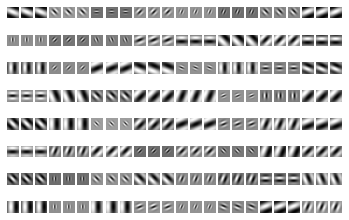

In [38]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape
gabor_filters = W
for kernel_index in range(wshape[3]):
    for channel_index in range(3):
        gabor_filters[:,:,channel_index, kernel_index] = filterbank[kernel_index]

classifier.get_layer(name=cnnl1).set_weights([gabor_filters, classifier.get_layer(name=cnnl1).get_weights()[1]])
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, len(filter_layers)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig('caltech256-{}-initial-gabor-same-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')

In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = RMSprop(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 373s 485ms/step - loss: 7.6953 - accuracy: 0.0251 - auc: 0.5479 - val_loss: 5.4698 - val_accuracy: 0.0782 - val_auc: 0.6310
Epoch 2/1000
765/765 [==============================] - 372s 487ms/step - loss: 6.6039 - accuracy: 0.0569 - auc: 0.6102 - val_loss: 5.0465 - val_accuracy: 0.0846 - val_auc: 0.6786
Epoch 3/1000
765/765 [==============================] - 371s 485ms/step - loss: 6.3713 - accuracy: 0.0790 - auc: 0.6367 - val_loss: 5.8573 - val_accuracy: 0.0424 - val_auc: 0.6190
Epoch 4/1000
765/765 [==============================] - 369s 482ms/step - loss: 6.1689 - accuracy: 0.0940 - auc: 0.6578 - val_loss: 4.9232 - val_accuracy: 0.0947 - val_auc: 0.7048
Epoch 5/1000
765/765 [==============================] - 371s 485ms/step - loss: 6.0429 - accuracy: 0.1047 - auc: 0.6780 - val_loss: 4.5649 - val_accuracy: 0.1358 - val_auc: 0.7569
Epoch 6/1000
765/765 [==============================] - 372s 486ms/step - loss: 5.9496 - accuracy: 0

In [40]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 22423.627225101
Finish time = 43986.970754647
Training time = 21563.343529546


In [41]:
import pickle

with open('caltech256-{}-history-gabor-same-kernel-{}.p'.format(ITERATION, GABOR_HEIGHT), 'wb') as fp:
  pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

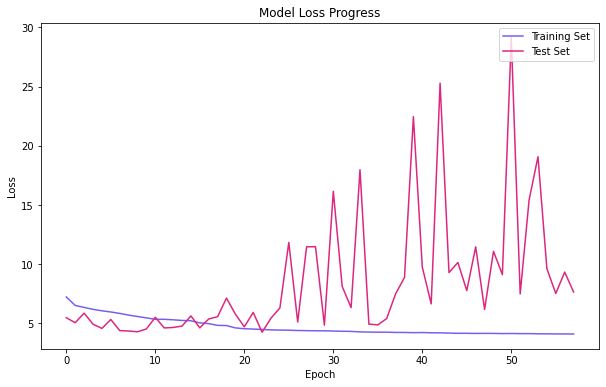

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

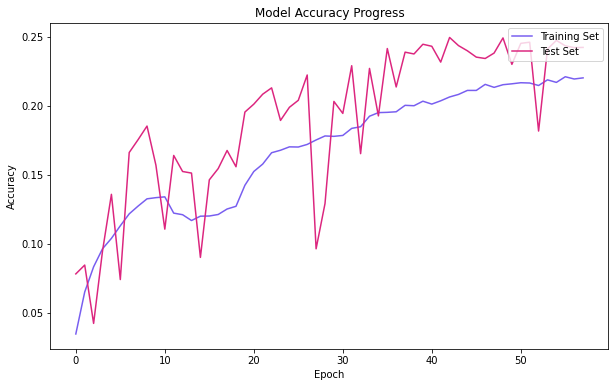

In [43]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-gabor-same-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

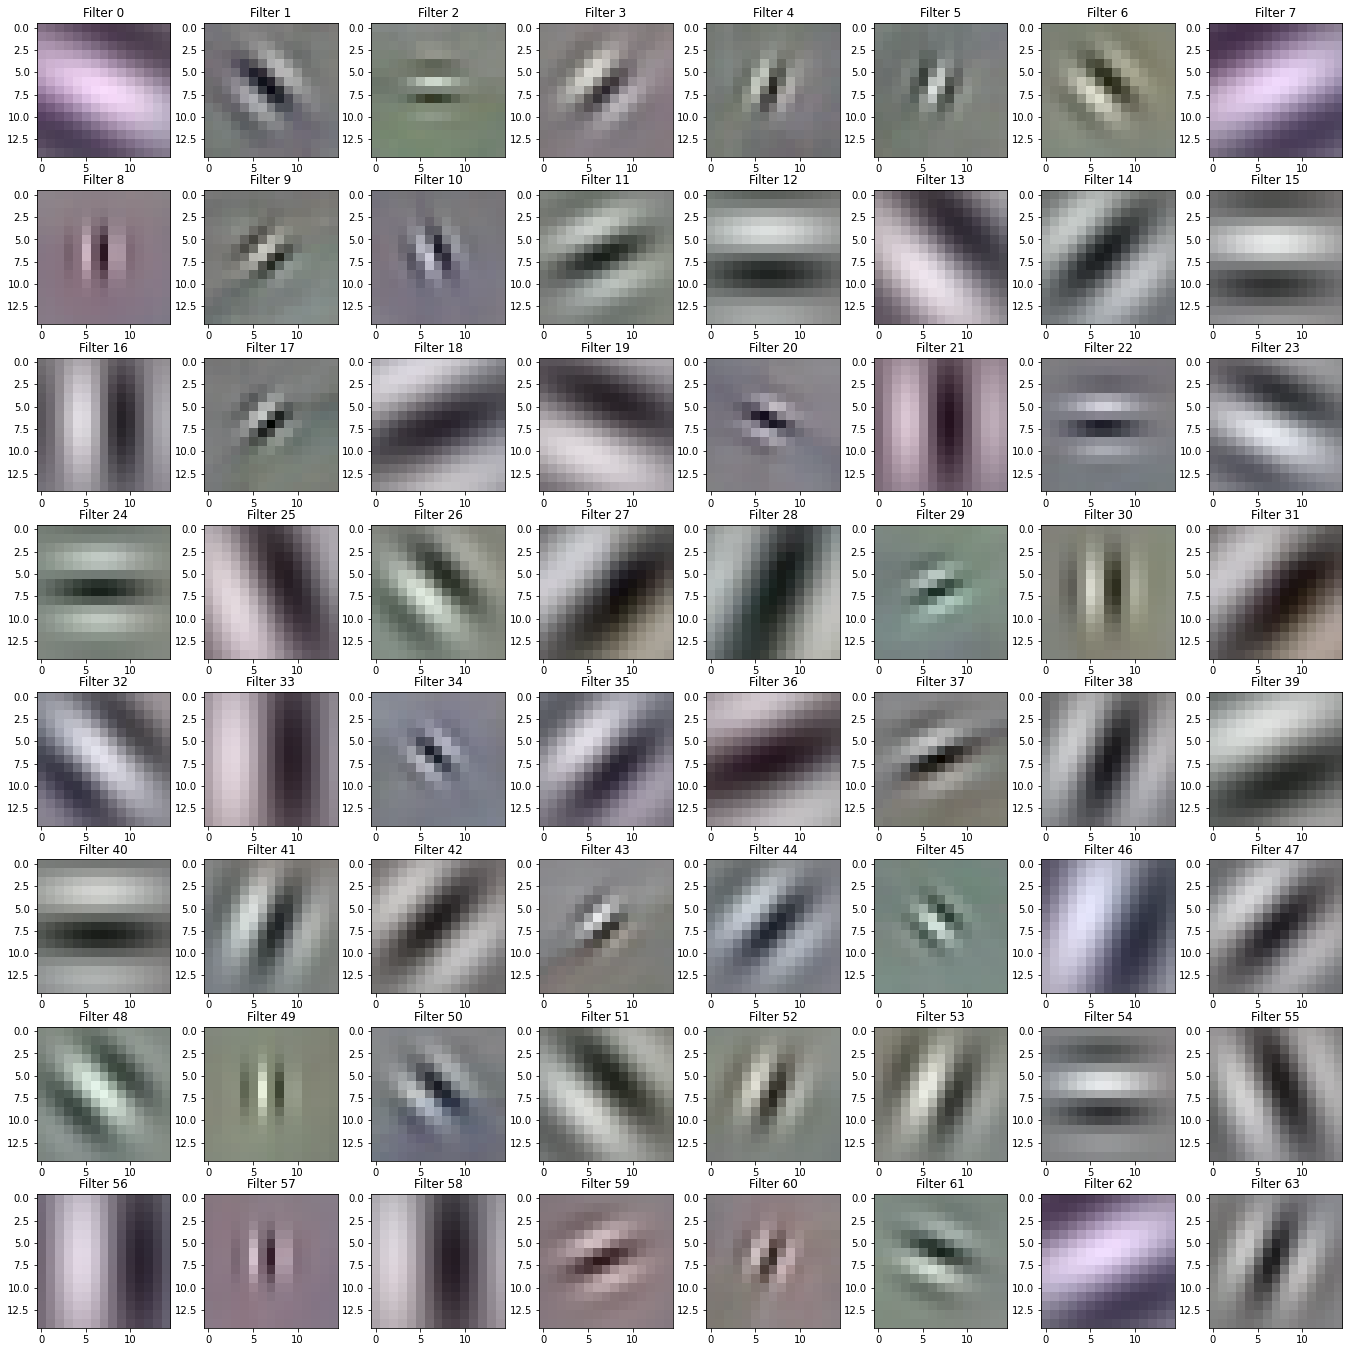

In [44]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-gabor-same-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)

-1.2477762 1.1975405


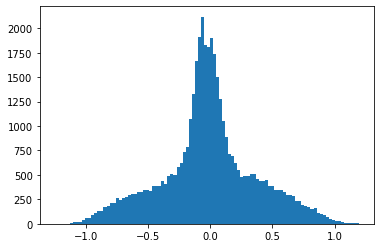

In [45]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

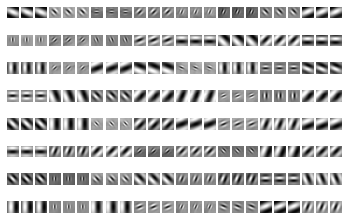

In [46]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-gabor-same-filters-kernel-{}.png".format(ITERATION, GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [47]:
!cp caltech256-2-initial-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/

In [48]:
!cp caltech256-2-history-gabor-same-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/

In [49]:
!cp caltech256-2-loss-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/

In [50]:
!cp caltech256-2-accuracy-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/

In [51]:
!cp caltech256-2-filters-gabor-same-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/

In [52]:
!cp caltech256-2-channelwise-gabor-same-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/caltech256-aspect-preserved/2/